# Train the Flood Classification Network

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from keras import Sequential
from keras.layers import InputLayer, LSTM, Dropout, Dense, Softmax
from keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

sns.set_style("whitegrid")

In [2]:
# To avoid:
# StdErr from Kernel Process OMP: Error #15: Initializing libiomp5md.dll, but found libiomp5 already initialized.
# OMP: Hint This means that multiple copies of the OpenMP runtime have been linked into the program.

import os

os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

Import data set and corresponding labels.

In [3]:
dataset = tf.data.Dataset.list_files("../data/flooddata/*/*.csv", shuffle=False)

files = []
for file in dataset:
    files.append(file.numpy().decode())

labels = []
for file in files:
    labels.append(file.split("\\")[3])

files = np.array(files)
labels = pd.Categorical(labels).rename_categories(["0.0 ft", "0.19 ft", "2.5 ft", "4.5 ft"])

In [4]:
files_train, files_test, labels_train, labels_test = train_test_split(files, labels, test_size=0.2, stratify=labels)
files_test, files_validation, labels_test, labels_validation = train_test_split(files_test, labels_test, test_size=0.5, stratify=labels_test)

le = LabelEncoder()
le.fit(labels)

labels_train = le.transform(labels_train)
labels_train = tf.one_hot(labels_train, 4)

labels_test = le.transform(labels_test)
labels_test = tf.one_hot(labels_test, 4)

labels_validation = le.transform(labels_validation)
labels_validation = tf.one_hot(labels_validation, 4)

Split the data set into three sets for training, validation, and testing.

In [5]:
def load_array(file):
    df = pd.read_csv(file)
    array = df.to_numpy().T
    return array

def create_dataset(files, labels):
    arrays = list(map(load_array, files))
    dataset = tf.data.Dataset.from_generator(lambda: iter(zip(arrays, labels)), output_types=(tf.float16, tf.uint8))
    return dataset

def configure_for_performance(dataset):
    dataset = dataset.cache()
    dataset = dataset.shuffle(buffer_size=222, reshuffle_each_iteration=True)
    dataset = dataset.padded_batch(32, padded_shapes=((3, 137), ([None])))
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

train_dataset = create_dataset(files_train, labels_train.numpy())
train_dataset = configure_for_performance(train_dataset)

test_dataset = create_dataset(files_test, labels_test.numpy())
test_dataset = configure_for_performance(test_dataset)

validation_dataset = create_dataset(files_validation, labels_validation.numpy())
validation_dataset = configure_for_performance(validation_dataset)

Create the model.

In [6]:
model = Sequential([InputLayer(input_shape=(3, 137)),
                    LSTM(128, return_sequences=False), 
                    Dropout(0.5),
                    Dense(units=4), 
                    Softmax()])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               136192    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 4)                 516       
                                                                 
 softmax (Softmax)           (None, 4)                 0         
                                                                 
Total params: 136,708
Trainable params: 136,708
Non-trainable params: 0
_________________________________________________________________


Compile the model.

In [7]:
optimizer = Adam(learning_rate=0.001)
loss = tf.keras.losses.CategoricalCrossentropy()
metrics = tf.keras.metrics.CategoricalAccuracy()
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

Train the model.

In [8]:
history = model.fit(train_dataset, epochs=15, validation_data=validation_dataset)

Epoch 1/15


6/6 [==============================] - 4s 422ms/step - loss: 1.3614 - categorical_accuracy: 0.3785 - val_loss: 1.3834 - val_categorical_accuracy: 0.4348
Epoch 2/15
6/6 [==============================] - 0s 5ms/step - loss: 1.1891 - categorical_accuracy: 0.6158 - val_loss: 1.3240 - val_categorical_accuracy: 0.5652
Epoch 3/15
6/6 [==============================] - 0s 6ms/step - loss: 1.0882 - categorical_accuracy: 0.7006 - val_loss: 1.2698 - val_categorical_accuracy: 0.6087
Epoch 4/15
6/6 [==============================] - 0s 6ms/step - loss: 0.9995 - categorical_accuracy: 0.8531 - val_loss: 1.2103 - val_categorical_accuracy: 0.6522
Epoch 5/15
6/6 [==============================] - 0s 6ms/step - loss: 0.8870 - categorical_accuracy: 0.8757 - val_loss: 1.1543 - val_categorical_accuracy: 0.6522
Epoch 6/15
6/6 [==============================] - 0s 6ms/step - loss: 0.7869 - categorical_accuracy: 0.9153 - val_loss: 1.1098 - val_categorical_accuracy: 0.6957
Epoch 7/15
6/6 [=====================

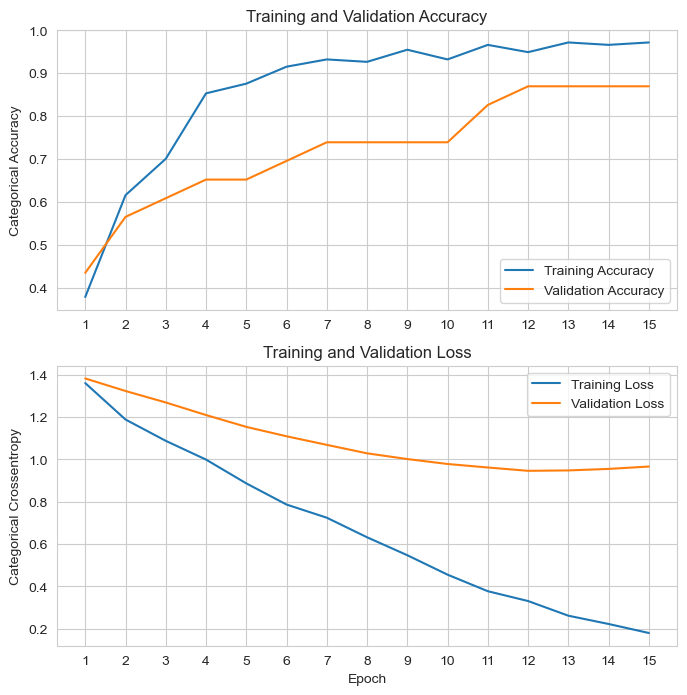

In [9]:
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Categorical Accuracy')
plt.title('Training and Validation Accuracy')
plt.xticks(range(len(acc)), range(1, len(acc)+1))

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Categorical Crossentropy')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.xticks(range(len(loss)), range(1, len(loss)+1))

plt.show()

Evaluate the model.

In [10]:
for signal, label in test_dataset:
   y_true = tf.argmax(label, axis=-1)
   predictions = model.predict(signal, verbose=False)
   y_pred = tf.argmax(predictions, axis=-1)

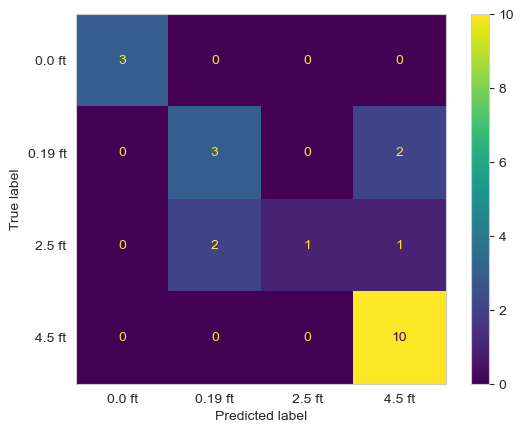

In [11]:
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["0.0 ft", "0.19 ft", "2.5 ft", "4.5 ft"])
disp.plot()
plt.grid(False)
plt.show()